# Coursework 1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Lab cluster, where you can access GPUs.

Please refer to the Intro lecture for getting set up on the various GPU options.

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

<font color="orange">**The deadline for submission is Tuesday, 6 Feb by 6 pm** </font>

In [2]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn

In [3]:
# Initialization Cell
try:
    WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
    USERNAME = 'your_username' # If working on Lab Machines - Your college username
    assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        d1_cw1_repo_path = 'Lectureship/CW/dl_cw1/' # path in your gdrive to the repo
        content_path = f'/content/drive/MyDrive/{d1_cw1_repo_path}' # path to gitrepo in gdrive after mounting
        drive.mount('/content/drive/') # Outputs will be saved in your google drive

    elif WORKING_ENV == 'LABS':
        content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw1/' # You may want to change this
        # Your python env and training data should be on bitbucket
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )

    elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
        # Paperspace does not properly render animated progress bars
        # Strongly recommend using the JupyterLab UI instead of theirs
        !pip install ipywidgets
        content_path = '/notebooks'

    elif WORKING_ENV == 'SAGEMAKER':
        content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'
    else:
        raise NotImplementedError()

    import otter
    import os
    if not os.path.exists(f'{content_path}tests'):
        raise ValueError('Cannot find the public tests folder')
    grader = otter.Notebook(
        f'{content_path}dl_cw_1.ipynb',
        tests_dir=f'{content_path}tests')
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    import otter
    grader = otter.Notebook("dl_cw_1.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90


## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride       = (stride, stride) if isinstance(stride, int) else stride
        self.padding      = (padding, padding) if isinstance(padding, int) else padding

        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        self.w = nn.Parameter(torch.randn((out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])))
        # Bias should have shape [out_channels] 
        self.b = nn.Parameter(torch.randn((out_channels))) if bias else None
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass 
        # Define the input dimensions
        N, C, H, W = x.size()
        H_prime = self.kernel_size[0]
        W_prime = self.kernel_size[1]
        
        # Unfold the input
        x_unf = F.unfold(x, kernel_size = (H_prime, W_prime), padding = self.padding, stride = self.stride)
        
        # Perform convolution and add biases
        out_unf = x_unf.transpose(1,2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1,2)
        out_unf += self.b.view(1, -1, 1)
        
        # Calculate output dimensions
        H_out = (H + 2 * self.padding[0] - H_prime) // self.stride[0] + 1
        W_out = (W + 2 * self.padding[1] - W_prime) // self.stride[1] + 1
        
        # Coerce output into correct dimensions
        out = out_unf.view(N, self.out_channels, H_out, W_out)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out 

In [5]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kernel_size  = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        N, C, H, W = x.size()
        H_prime = self.kernel_size[0]
        stride_H = self.kernel_size[0]
        W_prime = self.kernel_size[1]
        stride_W = self.kernel_size[1]
        
        # Unfold the output
        x_unf = F.unfold(x, kernel_size = (H_prime, W_prime), stride=(stride_H, stride_W))
        
        # Reshape the unfolded tensor to have the same shape as the output
        x_unf_reshaped = x_unf.view(N, C, H_prime*W_prime, H // stride_H, W // stride_W)

        # Perform a 2D max pooling
        out, _ = x_unf_reshaped.max(dim=2)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


In [7]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [8]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.in_channels = in_channels
        self.out_channels = out_channels
        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = nn.Parameter(torch.rand((self.in_channels, self.out_channels)))
        self.b = nn.Parameter(torch.randn((out_channels))) if bias else None
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #N = x.shape[0]
        #H = x.shape[-1]
        out = x @ self.w
        
        if self.b is not None:
            out += self.b
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [9]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [10]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: the value used for the running_mean and running_var
        computation. Default: 0.1 . (i.e. 1-momentum for running mean)
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # The learnable parameters
        self.gamma = torch.ones((num_features))
        self.beta = torch.zeros((num_features))

        # Running mean and variance
        self.running_mean = nn.Parameter(torch.zeros(num_features), requires_grad=False)
        self.running_var = nn.Parameter(torch.ones(num_features), requires_grad=False)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Calculate mean and variance along dimensions N, H, W
        mean = x.mean(dim=(0, 2, 3), keepdim=True)
        var_biased = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)

        # We want to update the mean and variance during training
        if self.training:
            self.running_mean = torch.nn.Parameter((1 - self.momentum) * self.running_mean + self.momentum*mean.squeeze())

            # Note that the update of the running variance uses the unbiased estimation of variance
            var_unbiased = x.var(dim=(0, 2, 3), unbiased=True, keepdim=True)
            self.running_var = torch.nn.Parameter((1 - self.momentum)*self.running_var + self.momentum*var_unbiased.squeeze())

        # Use running mean and biased variance during evaluation
        else:
            mean = self.running_mean
            var_biased = self.running_var

        # Finally, perform the batch normalisation
        x_normalised = (x-mean)/torch.sqrt(var_biased + self.eps)
        x = self.gamma.view(1, -1, 1, 1)*x_normalised + self.beta.view(1, -1, 1, 1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return x

In [11]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (28 points)
    * 8 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (12 points)

**Downloading NaturalImageNet**

In [16]:
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else: 
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null


KeyboardInterrupt



In [12]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [13]:
# When we import the images we want to first convert them to a tensor. 
# It is also common in deep learning to normalise the the inputs. This 
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images 
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html
ON_COLAB = False
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number! 
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [14]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images** 

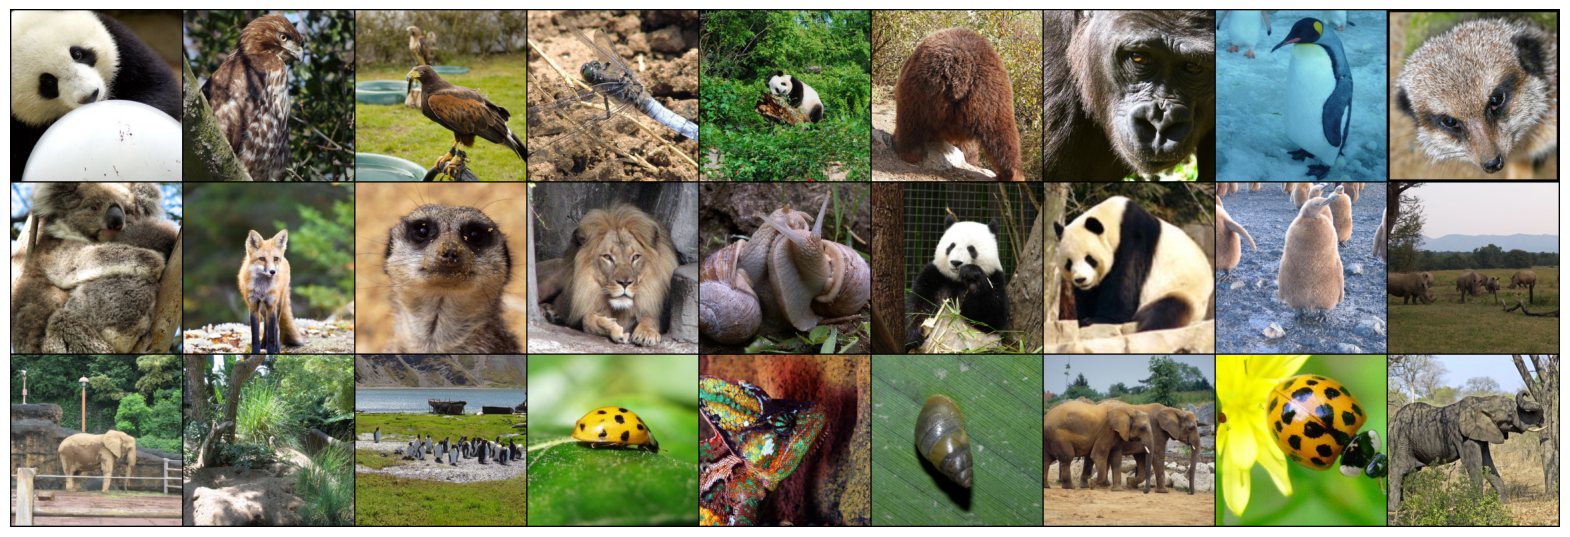

In [16]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Try a different ResNet block architecture, batch norm after addition

In [16]:
# define ResNet building blocks as per p.52 of slides: (i) batch norm after addition
if False:
    class ResidualBlockBNAA(nn.Module):
        def __init__(self, inchannel, outchannel, stride=1):
            super(ResidualBlockBNAA, self).__init__()
            self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                             stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(outchannel),
                                      nn.ReLU(inplace=True),
                                      Conv2d(outchannel, outchannel, kernel_size=3,
                                      stride=1, padding=1, bias=False))
            self.shortcut = nn.Sequential() 
            if stride != 1 or inchannel != outchannel: 
                self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                     kernel_size=1, stride=stride, 
                                                     padding = 0, bias=False), 
                                              nn.BatchNorm2d(outchannel)) 
            self.right = nn.Sequential(nn.BatchNorm2d(outchannel))

        def forward(self, x):
            out = self.left(x)
            out += self.shortcut(x)
            out = self.right(out)
            out = F.relu(out) 
            return out

    class ResNetBNAA(nn.Module):

        def __init__(self, ResidualBlockBNAA, num_classes = 20):

            super(ResNetBNAA, self).__init__()

            self.inchannel = 16
            self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
                                                padding = 1, bias = False), 
                                      nn.BatchNorm2d(16), 
                                      nn.ReLU())

            self.layer1 = self.make_layer(ResidualBlockBNAA, 16, 2, stride = 2)
            self.layer2 = self.make_layer(ResidualBlockBNAA, 32, 2, stride = 2)
            self.layer3 = self.make_layer(ResidualBlockBNAA, 64, 2, stride = 2)
            self.layer4 = self.make_layer(ResidualBlockBNAA, 128, 2, stride = 2)
            self.layer5 = self.make_layer(ResidualBlockBNAA, 256, 2, stride = 2)
            self.layer6 = self.make_layer(ResidualBlockBNAA, 512, 2, stride = 2)
            self.maxpool = MaxPool2d(4)
            self.fc = nn.Linear(512, num_classes)


        def make_layer(self, block, channels, num_blocks, stride):

            strides = [stride] + [1] * (num_blocks - 1)

            layers = []

            for stride in strides:

                layers.append(block(self.inchannel, channels, stride))

                self.inchannel = channels

            return nn.Sequential(*layers)


        def forward(self, x):

            x = self.conv1(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

    # please do not change the name of this class
    def MyResNetBNAA():
        return ResNetBNAA(ResidualBlockBNAA)

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None, 
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [18]:
import csv
USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)
    

print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
                stack_labels = y
                stack_predicts = preds
            elif analysis:
                stack_labels = torch.cat([stack_labels, y], 0)
                stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
            print('check acc', type(stack_predicts), type(stack_labels))
            confusion(stack_predicts, stack_labels)
            incorrect_preds(preds, y, x)
            
        return float(acc)
        
        
def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                save_training_results_to_csv(e, t, loss.item())
        acc = check_accuracy(loader_val, model)
        save_accuracy(acc)

def save_training_results_to_csv(e, t, loss, filename='training_log.csv'):
    # Save training metrics to a CSV file
    try:
        with open(filename, mode='a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            
            # Check if the file is empty and write header if needed
            if csvfile.tell() == 0:
                csv_writer.writerow(['Epoch', 'Iteration', 'Loss'])
            
            # Write the data
            csv_writer.writerow([e, t, loss])
            
    except Exception as e:
        print(f"Error writing to CSV: {e}")
        

def save_accuracy(acc, filename='training_accuracy.csv'):
    # Save accuracy to a CSV file
    try:
        with open(filename, mode='a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            
            # Check if the file is empty and write header if needed
            if csvfile.tell() == 0:
                csv_writer.writerow(['Accuracy'])
            
            # Write the data
            csv_writer.writerow([acc])
            
    except Exception as e:
        print(f"Error writing to CSV: {e}")
                

cuda:0


Implementing RESNET-50 architecture as per He et al. (2016)

In [19]:
# We want to define the ResNet Architecture for 50, as given in He et al.

# Rather than the usual Residual Blocks, for this deeper architecture we require Bottleneck blocks.

class BottleNeckBlock(nn.Module):
    # We need a scale factor for the number of output channels at the end of each batchnorm.
    # The table on p.5 of the paper shows that this is 4, e.g. in conv2_x we go from 64 -> 256.
    expansion_factor = 4
    
    def __init__(self, in_channels, out_channels, stride=1, first_block_bool = False):
        """
        Initialise the BottleNeckBlock, see p.6 of He et al. for a schematic
        Arguments:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            stride (int): This has to vary depending on the convolution, both 3x3 and 1x1. 
            first_block_bool (bool): whether the first residual block in a layer
        """
        super().__init__() # inherit from nn.Module
        
        # The bottleneck has conv 1x1 -> conv 3x3 -> conv 1x1 with batchnorms between, relu at end
        # Convolution 1
        self.conv1 = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = 1, stride = 1, padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)

        # Convolution 2
        self.conv2 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = 3, stride = stride, padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)        

        # Convolution 3
        self.conv3 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels*self.expansion_factor,
                               kernel_size = 1, stride = 1, padding = 0)
        self.batchnorm3 = nn.BatchNorm2d(out_channels*self.expansion_factor)      
        
        # Finally, pass a ReLU ahead of next layer
        self.relu = nn.ReLU()
        
        # With the skip connection, we need to ensure that the dimensions match the output
        # of g(x) in order to perform addition. Hence, we need to downsample the skip connection.
        self.downsample = None
        # Downsample the first residual block
        if first_block_bool:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                                                      out_channels = out_channels*self.expansion_factor,
                                                      kernel_size = 1,
                                                      stride = stride,
                                                      padding = 0),
                                            nn.BatchNorm2d(out_channels*self.expansion_factor))
       
        # Now we are ready to define the forward pass for this convolution layer
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.conv3(x)
        x = self.batchnorm3(x)
            
        if self.downsample:
            identity = self.downsample(identity)
                
        x += identity # perform the addition
        x = self.relu(x)
        return x

    
# Next, define the model itself

class ResNet50(nn.Module):
    def __init__(self, ResBlock, num_classes = 20,
                 n_blocks = [3, 4, 6, 3], # refer to Table 1, p.6
                 out_channels = [64, 128, 256, 512],
                 num_channels = 3): # let's parameterise this in case we get different inputs
        """ Arguments:
        ResBlock: for ResNet50 we will use the bottleneck as defined above, not the basic one
        num_classes: this is 20 as we're trying to identify 20 kinds of animal
        n_blocks: number of residual blocks for each convolution layer (conv2_x to conv5_x)
        out_channels: the output channels for each conv layer (conv2_x to conv5_x)
        num_channels: 3 in this case for (r,g,b) images
        """
        super().__init__()
        
        # The first layer, conv1: 7x7, 64, stride 2
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = num_channels,
                                             out_channels = 64,
                                             kernel_size = 7,
                                             stride = 2,
                                             padding = 3),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size = 3,
                                                stride = 2, padding = 1))
        
        # Create the four convolutional layers (conv2_x to conv5_x)
        in_channels = 64 # should be equal to output channels from conv1
        # For first block of the second layer, don't downsample
        self.conv2_x = self.CreateLayer(ResBlock, n_blocks[0], 
                                        in_channels, out_channels[0], stride=1)
        
        # For the first three blocks of layers conv3_x to conv5_x, downsample and 
        # use a stride of 2. See Table 1 caption.
        self.conv3_x = self.CreateLayer(ResBlock, n_blocks[1],
                                        out_channels[0]*ResBlock.expansion_factor,
                                        out_channels[1], stride = 2)
        self.conv4_x = self.CreateLayer(ResBlock, n_blocks[2],
                                        out_channels[1]*ResBlock.expansion_factor,
                                        out_channels[2], stride = 2)
        self.conv5_x = self.CreateLayer(ResBlock, n_blocks[3],
                                        out_channels[2]*ResBlock.expansion_factor,
                                        out_channels[3], stride = 2)
        
        # Average pooling for classification head -- see bottom row of Table 1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc = nn.Linear(out_channels[3]*ResBlock.expansion_factor, num_classes)
        
        
    # Define the forward pass
    def forward(self, x):
        """
        Arguments:
            x: input image
                
        Returns:
            y: Output class
        """
        x = self.conv1(x)
            
        # Feature maps per convolution layer
        c2 = self.conv2_x(x)
        c3 = self.conv3_x(c2)
        c4 = self.conv4_x(c3)
        c5 = self.conv5_x(c4)
            
        # Classification head
        out = self.avgpool(c5)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
            
        return out
        
    # Define ancillary CreateLayer method
    def CreateLayer(self, ResBlock, n_blocks, in_channels, out_channels, stride=1):
        """ 
        Create a layer with the type and number of blocks -- see Table 1 for details.
        Arguments:
            ResBlock: BottleNeck for our ResNet-50
            n_blocks: number of residual blocks
            in_channels: number of input channels
            out_channels: number of output channels
            stride: stride used in first 3x3 conv of first residual block of the layer
            and 1x1 conv for the skip connection within that block
        """
        layers = [] # we can use make_layer as a template but need to adapt for downsampling
        for i in range(n_blocks):
            if i == 0: # i.e. if first block of the layer
                layers.append(ResBlock(in_channels, out_channels,
                                           stride=stride, first_block_bool = True))
            else:
                # Keep the same size for the other three blocks of the layer.
                # We do this by setting stride = 1 and first_block_bool = False
                layers.append(ResBlock(out_channels*ResBlock.expansion_factor, out_channels))
                    
        return nn.Sequential(*layers)
               
# Keep name of old class to make sure everything runs smoothly
def MyResNet():
    return ResNet50(BottleNeckBlock)

Total number of parameters is: 23575572
Epoch: 0, Iteration 0, loss = 3.0540
Epoch: 0, Iteration 10, loss = 2.7019
Epoch: 0, Iteration 20, loss = 2.4670
Epoch: 0, Iteration 30, loss = 2.4722
Epoch: 0, Iteration 40, loss = 2.3140
Epoch: 0, Iteration 50, loss = 2.1986
Epoch: 0, Iteration 60, loss = 2.1562
Epoch: 0, Iteration 70, loss = 2.2449
Epoch: 0, Iteration 80, loss = 2.1805
Epoch: 0, Iteration 90, loss = 2.1642
Epoch: 0, Iteration 100, loss = 2.1325
Epoch: 0, Iteration 110, loss = 1.8452
Epoch: 0, Iteration 120, loss = 1.9081
Epoch: 0, Iteration 130, loss = 1.9394
Epoch: 0, Iteration 140, loss = 1.9696
Got 813 / 1998 correct of val set (40.69)
Epoch: 1, Iteration 0, loss = 1.8959
Epoch: 1, Iteration 10, loss = 1.5423
Epoch: 1, Iteration 20, loss = 1.6116
Epoch: 1, Iteration 30, loss = 1.8095
Epoch: 1, Iteration 40, loss = 1.6840
Epoch: 1, Iteration 50, loss = 1.8619
Epoch: 1, Iteration 60, loss = 1.4140
Epoch: 1, Iteration 70, loss = 1.5001
Epoch: 1, Iteration 80, loss = 1.5897
Epo

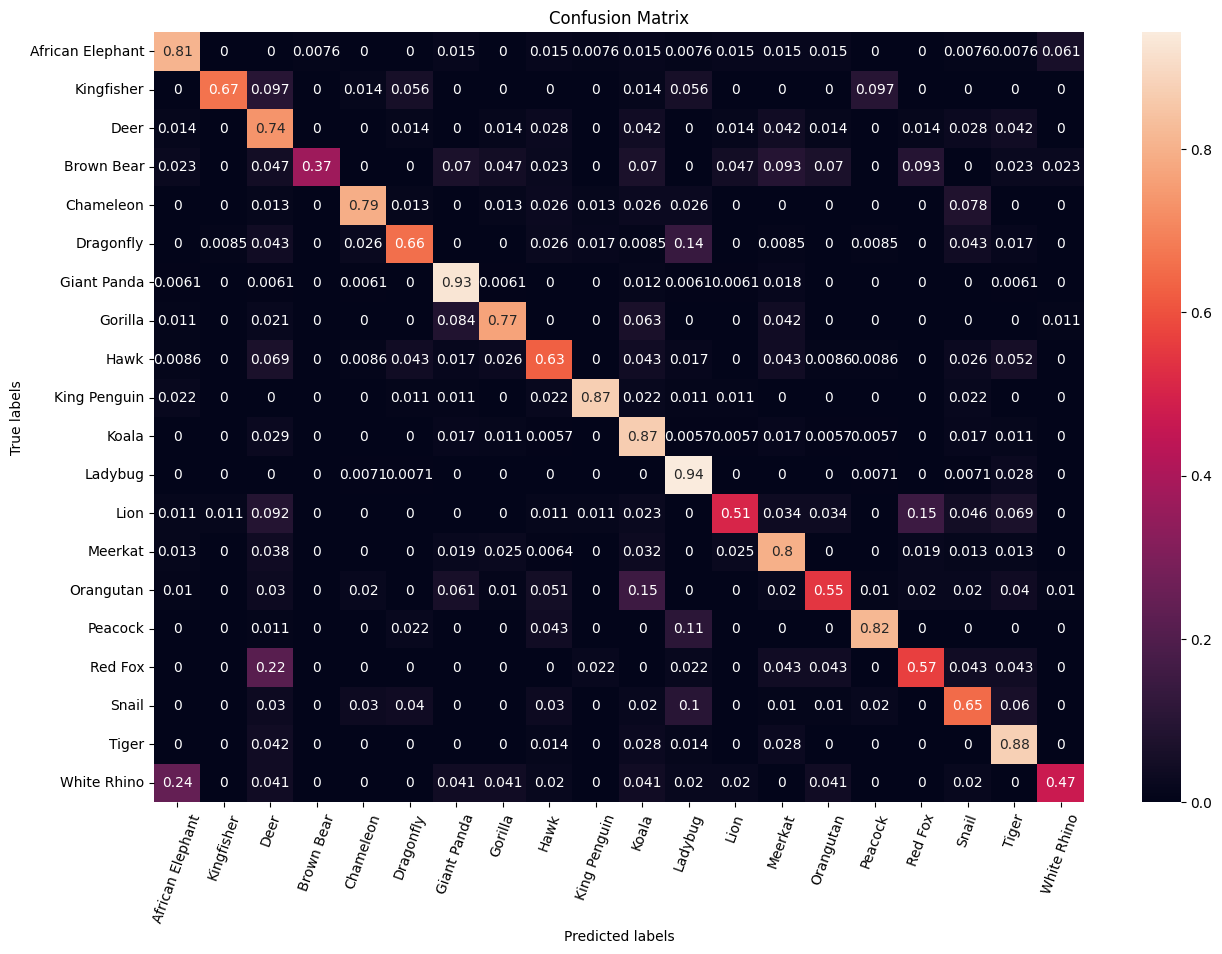

Predicted label ['Koala' 'Meerkat' 'Dragonfly' 'King Penguin' 'Meerkat' 'Deer' 'Deer'
 'Giant Panda' 'Red Fox']
True label ['Deer' 'Orangutan' 'Snail' 'Red Fox' 'Giant Panda' 'Meerkat' 'Snail'
 'Gorilla' 'Brown Bear']
Corresponding images are shown below


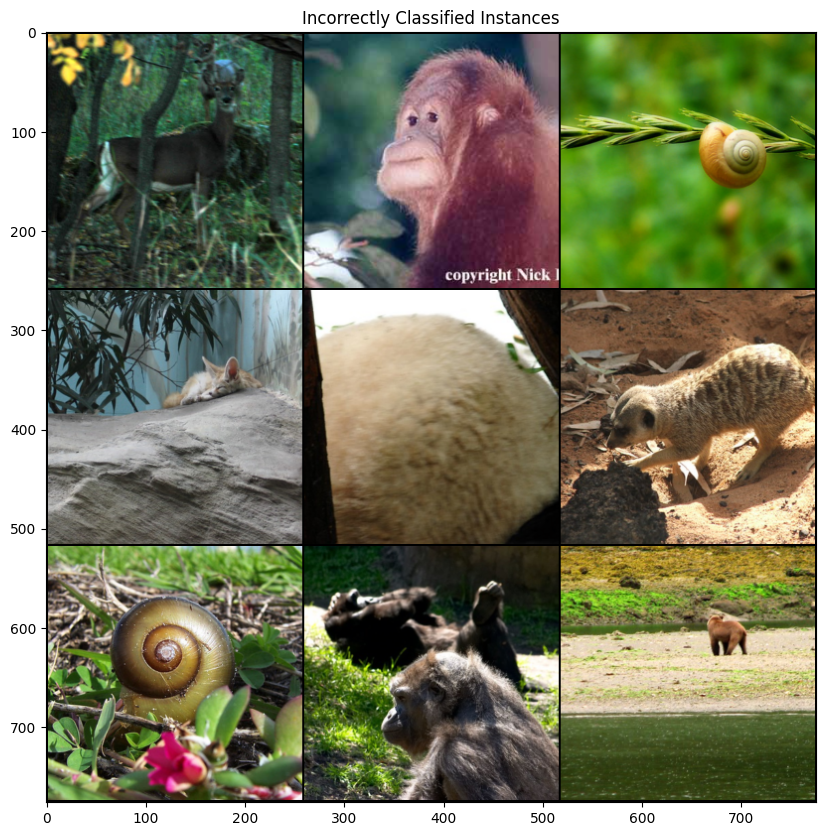

In [20]:
# define and train the network
model = MyResNet()

optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-7) 

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs = 10)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1408 / 2000 correct of val set (70.40)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


Predicted label ['Koala' 'African Elephant' 'Lion' 'Tiger' 'Orangutan' 'Snail' 'Hawk'
 'Koala' 'White Rhino']
True label ['Hawk' 'Gorilla' 'Brown Bear' 'Koala' 'Lion' 'Dragonfly' 'Tiger' 'Deer'
 'Lion']
Corresponding images are shown below


0.704

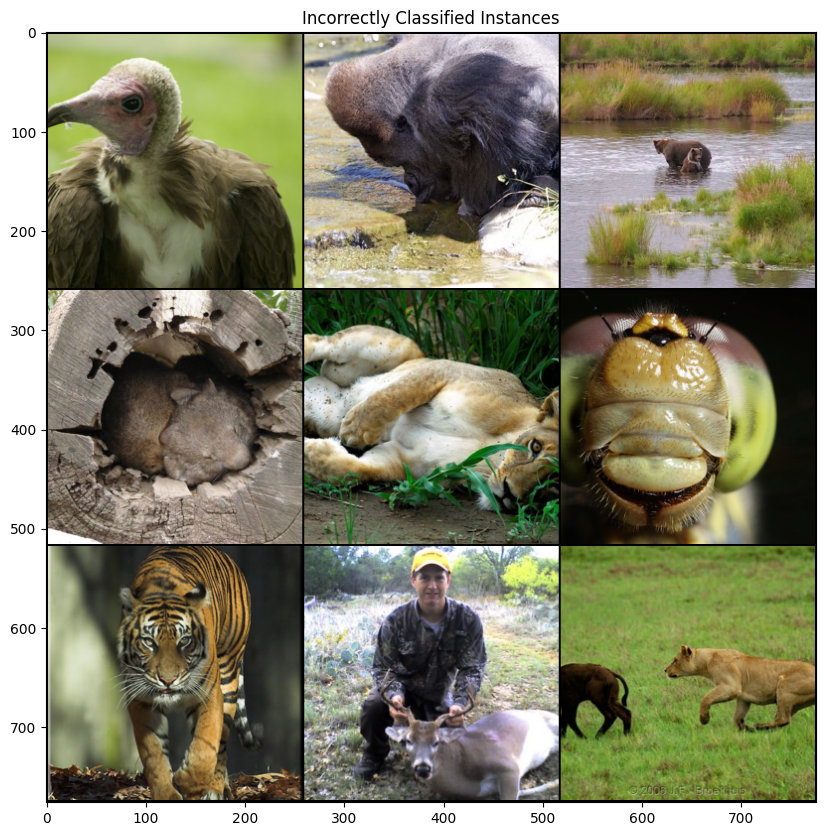

In [21]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

Due to the large dataset size and high number of parameters, an exhaustive grid search is not a viable approach. 

A good strategy would be to use an optimisation library - Ray Tune for example - which is geared towards Pythonic distributed computing. These packages tend to use early stopping with adaptive successive halving (ASHAScheduler) methods. This allows us to terminate less promising candidate hyperparameter values to speed up the optimisation process intelligently and increase the search space. Were this to be a model that I would deploy, I might want to use automated ML to automate the process of hyperparameter tuning, but given the large amount of set up to do this, in the instance of this coursework this was not the approach that I took.


Furthermore, it makes to identify a few key hyperparameters to focus on -- e.g. the learning rate, in_channels rather than trying everyting: the network is too big for that. In the end, I picked my hyperparameters for the model architecture extremely closely to the original paper by He et al. (2016), as I reasoned that they would have done much more work into this area, and so it made sense to leverage off their experience. Moreover, I focussed on just one hyperparameter, the learning rate. Trying different combinations of this resulted in meaningful improvement.


---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

My first approach was to try to change the ResNet block type as per p.52 of Lecture 4. I include an example of this (batch norm after addition) in an above code chunk (commented out). However, the performance increase was only marginal (an accuracy of 37% vs a baseline of 33%). Next, I tried increasing the number of in channels from 16 to 64, which increased accuracy to 38%. As these were relatively modest improvements, I felt that a more comprehensive approach might be the way to go.

To boost the baseline performance, I went back to the original article, "Deep Residual Learning for Image Recognition" by He et al. where they found that the deeper ResNet variants (50, 101, 152) were more accurate than the more shallow ResNet architectures by significant margins. They did not observe any degradation problem (i.e. where more layers reduces accuracy) and so it would seem too that in my implementation, by adding more depth I could improve the model results considerably. Accordingly, I implemented ResNet50 as specified in the article, closely following the architecture specifications of Table 1 on p.6 in the article.

The main change compared to the baseline results was the use of what the authors of the paper term "Bottleneck Architectures" where, for each building block, we stack three layers instead of two. In addition, there are 1x1 convolutions responsible for reducing and then increasing dimensions (hence the bottleneck name).

Due to the residual construction, deeper ResNet models perform better, avoiding degradation. The authors attribute depth to the improvement in performance vis-a-vis the shallower versions of ResNet (see top of p.7). 

Finally, I chose to implement ResNet-50 rather than the even deeper variants of 101 or 152 due to computing constraints/time and only marginal gains on offer from making the model architecture deeper from 50.

Once this was done, I then tried increasing the learning rate to boost performance further, reaching a test accuracy of just over 70%.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.3: Out of distribution evaluation

Lets see how your trained model performs when evaluated on cartoons of the 20 animal classes. Do not try and modify your model to perform well on this task, this is just a reflective exercise. How did your model perform at the task? Why do you think this was the case? Detail one method which you expect would improve model performance. (2 points)

In [31]:
ON_COLAB = False

!wget https://zenodo.org/records/10424022/files/cartoons.zip?download=1

if ON_COLAB:
    !unzip /content/cartoons.zip?download=1 > /dev/null

else:
    !unzip cartoons.zip?download=1 > /dev/null

--2024-02-04 17:41:14--  https://zenodo.org/records/10424022/files/cartoons.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737267 (1.7M) [application/octet-stream]
Saving to: ‘cartoons.zip?download=1.5’

cartoons.zip?downlo 100%[===================>]   1.66M  38.3KB/s    in 70s     

2024-02-04 17:42:30 (24.4 KB/s) - ‘cartoons.zip?download=1.5’ saved [1737267/1737267]

replace cartoons/gorilla/gorilla_6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [22]:
ON_COLAB = False
mean = torch.Tensor([0.485, 0.456, 0.406]) # assuming same dist as imagenet
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]

    )
cartoon_path = ('/content/' if ON_COLAB else '') + 'cartoons'


cartoon_dataset = datasets.ImageFolder(cartoon_path, transform=transform)

print(len(cartoon_dataset))

batch_size = 128

cartoon_loader = DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

400


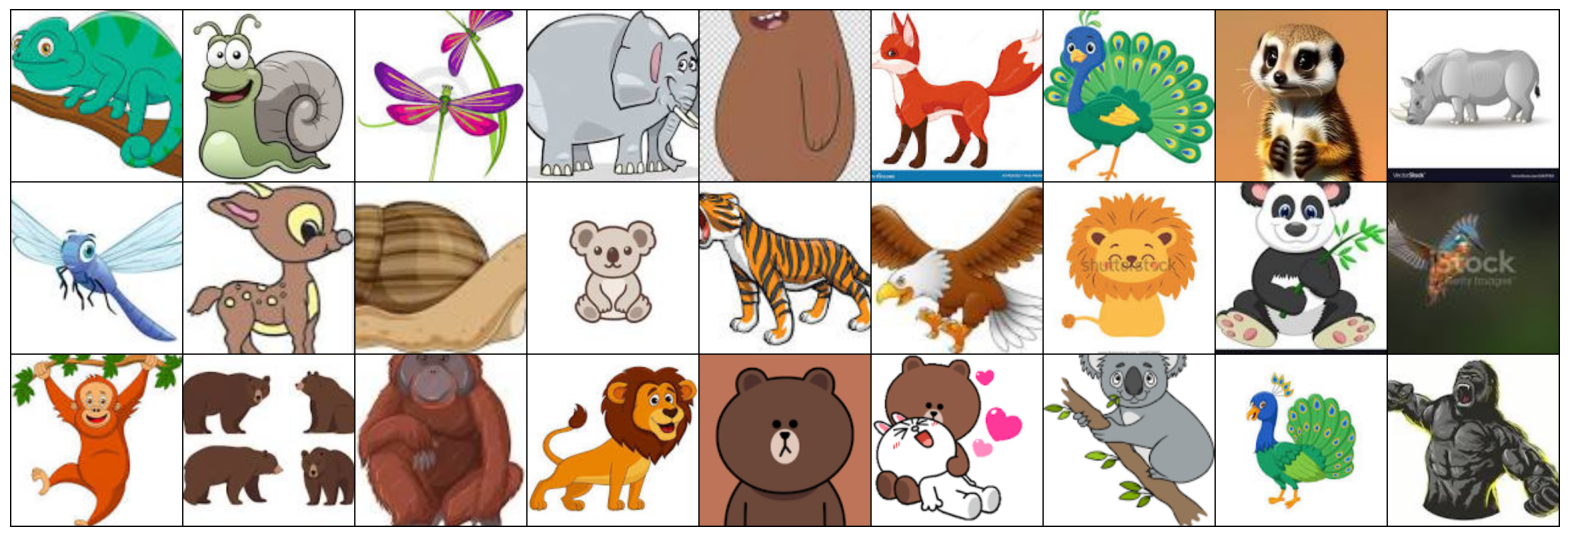

In [23]:
sample_inputs, _ = next(iter(cartoon_loader))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Got 86 / 400 correct of val set (21.50)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


Predicted label ['Tiger' 'Giant Panda' 'Ladybug' 'Meerkat' 'Hawk' 'Giant Panda' 'Ladybug'
 'Meerkat' 'Ladybug']
True label ['Hawk' 'Ladybug' 'Hawk' 'White Rhino' 'Deer' 'Gorilla' 'Tiger'
 'Orangutan' 'Kingfisher']
Corresponding images are shown below


0.215

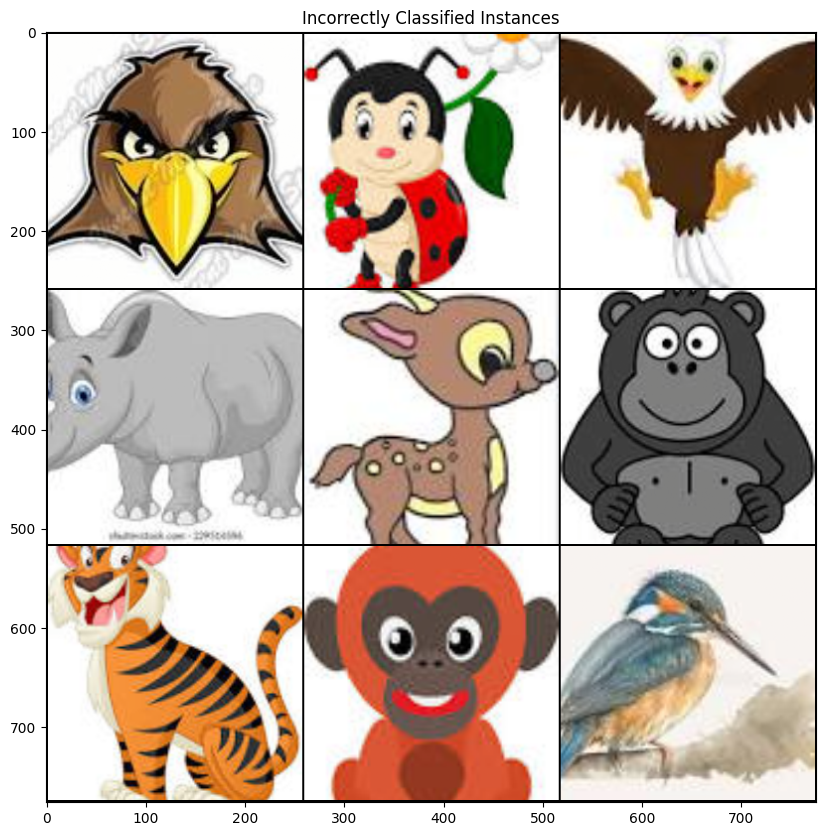

In [24]:
check_accuracy(cartoon_loader, model, analysis=True)

**Answer:**

My model performed rather poorly on cartoons (accuracy of 21.5%). Furthermore, performance was highly variable across different animals: similarly to the test set confusion matrix, images were often labelled as ladybug.

This is likely because the model is trained on photos of animals, and while cartoons of animals may sometimes bear some resemblance (e.g. colour), cartoons are likely to contain exagerrated and out-of-proportion features that our model will be unlikely to correspond with its training photos. 

To improve performance, I would consider fewer features/ using fewer convolutions/filters, hoping that the model might pick out a few features that end up being shared between photos and cartoons (e.g. rough shape, colour). Of course, an obvious approach to improve performance would be to train the model on the cartoon dataset too.

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

As the feature maps goes from lower to higher levels, the feature maps get more and more abstract, by which I (loosely) mean less recognisable as an animal image. There is also a corresponding reduction in pixels/dimensions due to the repeated convolutions as we move to higher layers. This means that the hidden layers become less interpretable, but to some extent that is part of the domain in deep learning.



---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

My model achieves a test set accuracy of around 70%, and represents a good reduction in the loss function value as epochs increase. Furthermore, the feature map appears to show how each layer of blocks is extracting more and more abstract features as the input passes through the model.I am also pleased that there is not a dramatic decrease in performance between training accuracy (75%) and test accuracy.

However, the performance is uneven, with the confusion matrix diagonal (i.e. correct predictions per animal) ranging from 0.22 (brown bear) to 0.94 (ladybug). Moreover, many animals are incorrectly labelled as dragonflys. When I ran this test previously, there were similarly a large number of mislabellings but on African Elephant. In addition, some of the misclassification appears concentrated (e.g. lots of white rhinos confused for elephants). 

There are two steps I would take to improve model performance. Firstly, I would consider altering the architecture of the ResNet to be even deeper, as the paper by He et al. (2016) show that deeper ResNet models improve accuracy further. Secondly, I would want to do a more comprehensive parameter optimisation/search than I managed to do in this project due to computing and time constraints. This would include exploring different in channels, training times/epochs, as well as other kinds of regularisation such as dropout rather than batchnorm. In many cases there is no strictly theoretically superior approach, and these kinds of deep learning exercises require a long time of trying various combinations and seeing what works.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

There are a few further ways to analyse model performance that I would be interested in:
- transfer learning: running the model on another dataset of animal photos; retraining the model on a new subset of animals
- computational efficiency: I have largely trusted in the GPUs and not bothered too much with worrying about parameter size etc. beyond the obvious checking of key inputs (e.g. batch size). Consequently, one aspect of performance not addressed above has been time/computational efficiency;
- robustness testing: it would be interesting to add some noise into the images to see how the model performs -- it appeared to struggle with images of e.g. a tiger shaking. Animals are often moving in photos so this could be an important aspect.
- average performance: ideally I would train the model several times on different seeds and take the average accuracy in order to get a truer sense of model performance, not just dependent on the particular sampling taken in train-val-test split.

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [25]:
import matplotlib.pyplot as plt

def plot_model_features(model, test_dataset):
    fig = plt.tight_layout()
    activation = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    vis_labels = ['conv1', 'conv2_x', 'conv3_x', 'conv4_x', 'conv5_x']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 640x480 with 0 Axes>

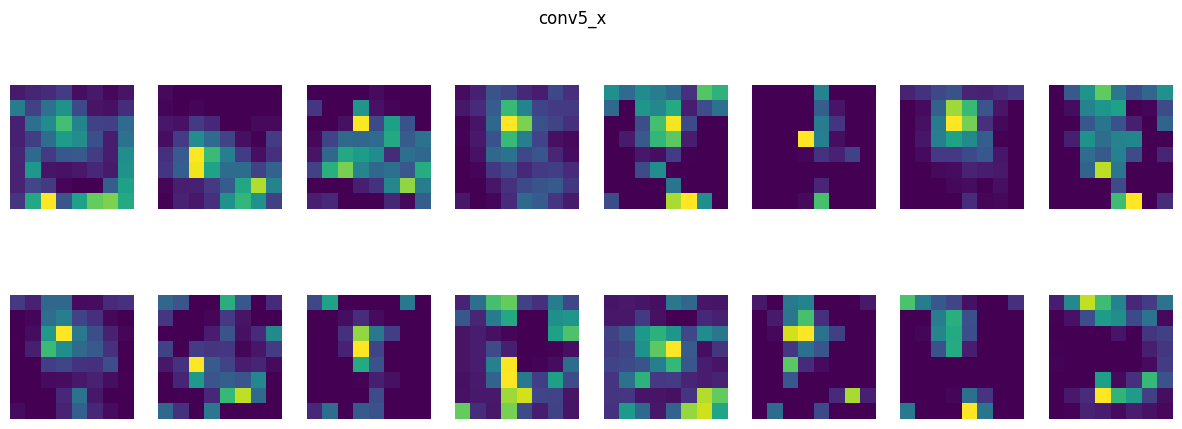

In [26]:
# Visualize the figure here, so it is exported nicely
plot_model_features(model = model, test_dataset = test_dataset)  

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [29]:
grader.check_all()

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

Convolution Layer results:
    Convolution Layer - 1 message: Shape Test Passed

    Convolution Layer - 1 result:
        ✅ Test case passed

    Convolution Layer - 2 message: Type Test Passed

    Convolution Layer - 2 result:
        ✅ Test case passed

    Convolution Layer - 3 message: Param Name Test Failed

    Convolution Layer - 3 result:
        ❌ Test case failed
        Trying:
            hasattr(Conv2d(1,1,1), 'w') and hasattr(Conv2d(1,1,1), 'b')
        Expecting:
            True
        **********************************************************************
        Line 1, in Convolution Layer 2
        Failed example:
            hasattr(Conv2d(1,1,1), 'w') and hasattr(Conv2d(1,1,1), 'b')
        Expected:
            True
  